In [1]:
import matplotlib.pyplot as plt
from capture_frames import DepthData
import numpy as np
import pickle
import cv2
from rpad.visualize_3d.plots import pointcloud_fig
import plotly.io as pio
import open3d as o3d
pio.renderers.default = "browser"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
with open("out.pkl", "rb") as f:
    data = pickle.load(f)
    frames = data["frames"]
    low, high = data["gray_mapping"]
    camera_matrix = data["camera_matrix"]
    distortion_coefficients = data["distortion_coefficients"]

In [3]:
len(frames)

7

In [4]:
def map_gray_image(gray_image, low, high):
    gray_image = gray_image.astype(np.float32).clip(low, high)
    gray_image = (gray_image - low) / (high - low) * 255
    gray_image = np.asarray(gray_image, dtype=np.uint8)
    gray_image = cv2.undistort(gray_image, camera_matrix, distortion_coefficients)
    return gray_image

In [5]:
def process_frame(frame: DepthData, gray_mapping):
    low, high = gray_mapping
    coords = cv2.undistort(frame.coords, camera_matrix, distortion_coefficients)
    coords = frame.coords * 1000 # meters to mm
    confidence = frame.confidence.reshape(-1,)
    coords_valid = coords.reshape(-1, 3)
    coords_valid = coords_valid[confidence > 0, :]
    gray_image = map_gray_image(frame.grayscale, low, high)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
    point_colors = gray_image.reshape(-1, 3)[confidence > 0, :]
    pcd = o3d.geometry.PointCloud(
        o3d.utility.Vector3dVector(coords_valid)
    )
    pcd.colors = o3d.utility.Vector3dVector(point_colors.astype(np.float32) / 255)
    return gray_image, coords, pcd

In [6]:
for idx, frame in enumerate(frames):
    coords, point_colors, pcd = process_frame(frame, data['gray_mapping'])
    o3d.io.write_point_cloud(f"frame_{idx}.ply", pcd)

In [169]:
frame = frames[0]
gray_image, coords, pcd = process_frame(frame, data['gray_mapping'])
gray_image.shape

(171, 224, 3)

In [170]:
fig = pointcloud_fig(np.asarray(pcd.points), colors=np.asarray(pcd.colors), downsample=1)
fig.show()

In [171]:
def estimate_extrinsics_by_procrustes(
    corners: np.ndarray,
    object_points: np.ndarray,
    point_cloud: np.ndarray,
):
    # corners: (N, 2)
    # point_cloud: (H, W, 3)
    image_points = corners.astype(np.int32).copy()
    image_points[:, 0] = np.clip(image_points[:, 0], 0, point_cloud.shape[1] - 1)
    image_points[:, 1] = np.clip(image_points[:, 1], 0, point_cloud.shape[0] - 1)
    # camera_points = point_cloud[image_points[:, 1], image_points[:, 0]]
    camera_points = point_cloud[
        image_points[:, 1],
        image_points[:, 0],
        :
    ]
    assert camera_points.shape == object_points.shape
    camera_centroid = np.mean(camera_points, axis=0)  # (3,)
    world_centroid = np.mean(object_points, axis=0)  # (3,)
    camera_centered = camera_points - camera_centroid.reshape(1, 3)
    world_centered = object_points - world_centroid.reshape(1, 3)
    covariance_matrix = camera_centered.T @ world_centered
    U, _, VT = np.linalg.svd(covariance_matrix)
    rotation_matrix = VT.T @ U.T
    translation = world_centroid - camera_centroid @ rotation_matrix.T

    corner_points_world = camera_points @ rotation_matrix.T + translation.reshape(
        1, 3
    )
    errors = np.linalg.norm(corner_points_world - object_points, axis=1)  # (N,)

    return errors.mean(), rotation_matrix, translation

In [172]:
xx, yy = np.meshgrid(np.arange(14) * 15, np.arange(9) * 15) # 15 mm blocks, 15 x 10
zz = np.zeros_like(xx)
object_points = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)


In [173]:
found, corners = cv2.findChessboardCorners(gray_image, (14, 9))
gray_image_copy = gray_image.copy()
cv2.drawChessboardCorners(gray_image_copy, (14, 9), corners, found)
errors, rotation, translation = estimate_extrinsics_by_procrustes(corners.reshape(-1, 2), object_points.reshape(-1, 3), coords)
errors

4.876953076242474

In [174]:
points_world = coords @ rotation.T + translation.reshape(1, 3)
pointcloud_fig(points_world.reshape(-1, 3), colors=gray_image.reshape(-1, 3), downsample=1).show()

In [175]:
def get_perblock_estimates(coords, confidence, checkerboard_dim, block_size):
    estimates = []
    nx, ny = checkerboard_dim
    xs = np.arange(nx) * block_size
    ys = np.arange(ny) * block_size
    for x_min, x_max in zip(xs, xs[1:]):
        row_estimates = []
        for y_min, y_max in zip(ys, ys[1:]):
            row_estimates.append(
                coords[(confidence > 0) & (coords[..., 0] > x_min) & (coords[..., 0] < x_max) & (coords[..., 1] > y_min) & (coords[..., 1] < y_max)]
            )
            # print(x_min, x_max, y_min, y_max, row_estimates[-1].shape)
        estimates.append(row_estimates)
    return estimates


In [176]:
perblock_estimates = get_perblock_estimates(points_world, frame.confidence, (14, 9), 15)
len(perblock_estimates), len(perblock_estimates[0])

(13, 8)

In [195]:
def collect_black_and_white_z(estimates):
    black_z = np.array([], dtype=np.float32)
    white_z = np.array([], dtype=np.float32)
    is_black_array = [] # return this array for visualization (and more importantly, bug detection)
    is_black = True # first block is black
    for row in estimates:
        is_black_row = []
        for block in row:
            if is_black:
                black_z = np.concatenate([black_z, block[:, 2]])
            else:
                white_z = np.concatenate([white_z, block[:, 2]])
            is_black_row.append(is_black)
            is_black = not is_black
        if(len(row) % 2 == 0):
            is_black = not is_black # each row has different starting color
        is_black_array.append(is_black_row)
    return black_z, white_z, is_black_array

In [196]:
black_z, white_z, is_black = collect_black_and_white_z(perblock_estimates)

In [197]:
white_z.min(), white_z.max(), black_z.min(), black_z.max(), white_z.mean(), black_z.mean()

(-11.034536091057134,
 17.27957815011439,
 -11.688955136382617,
 17.883415286019442,
 -0.5402459014445758,
 0.7239599662366092)

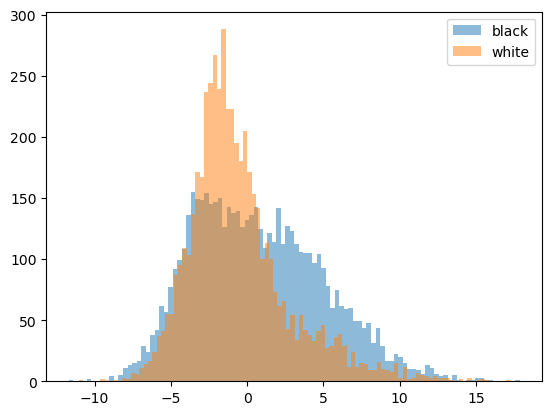

In [198]:
plt.hist(black_z, bins=100, alpha=0.5, label='black')
plt.hist(white_z, bins=100, alpha=0.5, label='white')
plt.legend()

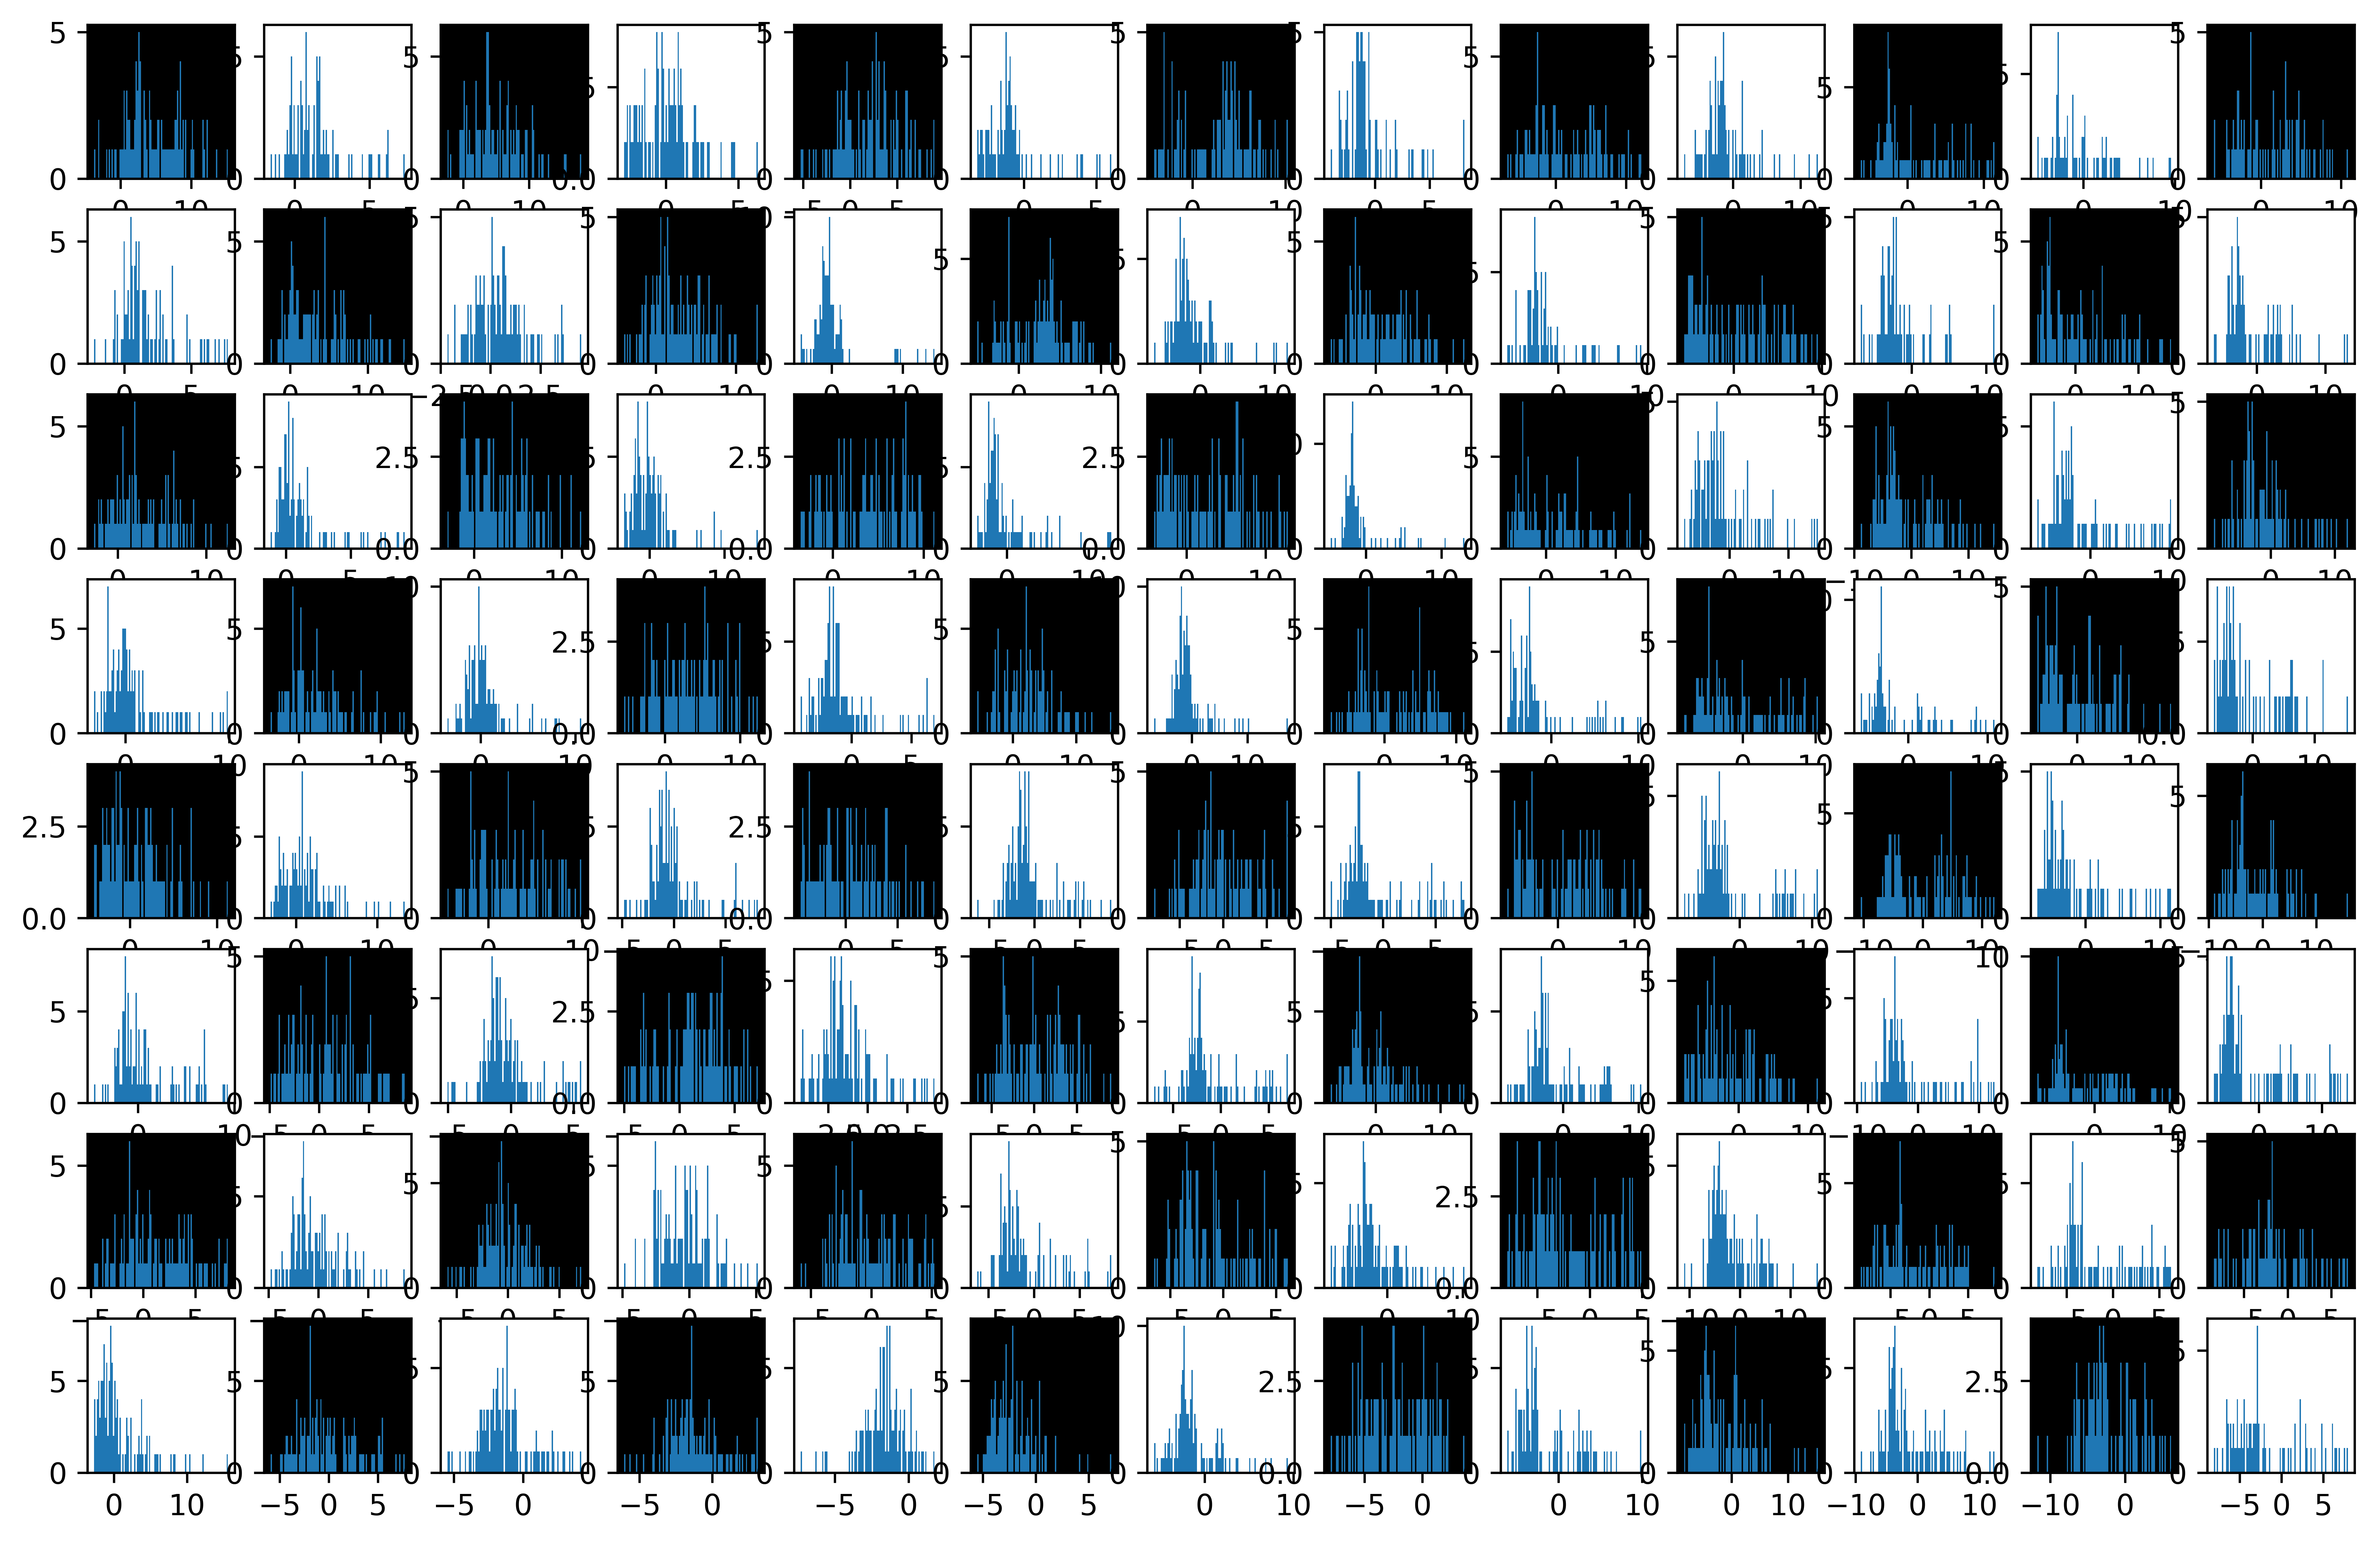

In [200]:
fig, axs = plt.subplots(8, 13, figsize=(14, 9), dpi=600)
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        if is_black[j][i]:
            ax.set_facecolor('black')
        else:
            ax.set_facecolor('white')
        ax.hist(perblock_estimates[j][i][..., 2], bins=100)
plt.savefig("depth_histograms.pdf")